In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import rcParams
import time
from copy import copy as dup
from scipy.integrate import solve_ivp

# My modules
import diffusionstuff10 as ds

In [2]:
# Graphics parameters
%matplotlib inline
ticklabelsize = 11
fontsize = 15
linewidth = 2

### The cell below specifies parameters for the 0-d and 1-d runs

D = 0.005 um^2/us 5.0 x 10^-9 m^2/sec
deltat_max (Diffusion time) = 50.0
deltat = 100.0
nu_kin_mlyperus = 0.8333333333333334 monolayers/us
nmid = 150
N* = 0.1432394487827058
N*x2pi = 0.9
Nbar, Nbar-N*, N*/Nbar = 1.0 0.8567605512172942 0.1432394487827058
deltax = 0.5
sigma_0 = 0.19
sigmaIcorner = 0.21
center reduction = 0.25 %
c_r = 0.0025 dimensionless
max growth rate = 52.5 um/sec
min growth rate = 4.999999999999998 um/sec
nu_kin = 250 um/sec
dx = 0.5
L = 75.0 micrometers


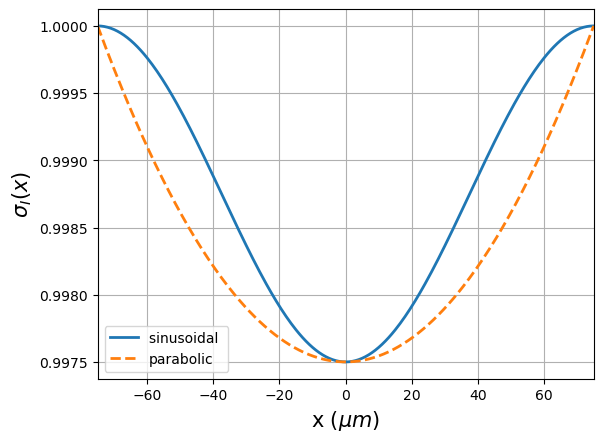

In [3]:
#Setting up the system
nx = 301 # Number of points in simulation box
xmax = 150
x = np.linspace(0, xmax, nx)
boxpoints = len(x)
deltax = x[1]-x[0]
Nbar = 1.0 # new Nbar from VMD, 260K
Nstar = .9/(2*np.pi)
nmid = int(nx/2)
xmid = max(x)/2
xmax = x[nx-1]
L = xmax/2

# Just conversions
nmpermonolayer = 0.3
umpersec_over_mlyperus = (nmpermonolayer/1e3*1e6)

# Diffusion coefficient
# D = 2e-3 # micrometers^2/microsecond
D = 5e-3 # micrometers^2/microsecond
# D = 1.6e-4 # micrometers^2/microsecond
# D = 6e-5 # micrometers^2/microsecond
# D = 8e-6 # micrometers^2/microsecond
# D = 2e-7 # micrometers^2/microsecond

# Time steps
dtmaxtimefactor = .5
dtmax = deltax**2/D
t_init = 0.0
deltat = dtmax/dtmaxtimefactor
tinterval = [t_init, t_init+deltat]

# Deposition rate
nu_kin = 34 # microns/second - about right for 240 K
nu_kin = 49 # microns/second - between 240 and 260 K
nu_kin = 250 # microns/second - about right for 260 K
nu_kin_mlyperus = nu_kin/umpersec_over_mlyperus # monolayers per microsecond

# Supersaturation
sigma0 = 0.19
sigmaIcorner = 0.20 # Must be bigger than sigma0 to get growth
sigmaIcorner = 0.21 # Must be bigger than sigma0 to get growth
center_reduction = 0.25 # In percent
c_r = center_reduction/100

# Diffusion coefficient scaled for this time step and space step
Doverdeltax2 = D/deltax**2

# Overlying supersaturation
sigmaI_sinusoid = ds.getsigmaI(x,xmax,center_reduction,sigmaIcorner,method='sinusoid')
sigmaI_parabolic = ds.getsigmaI(x,xmax,center_reduction,sigmaIcorner,method='parabolic')
# sigmaIstyle = 'sinusoid'
sigmaIstyle = 'parabolic'
if sigmaIstyle=='sinusoid':
    sigmaI = sigmaI_sinusoid
elif sigmaIstyle=='parabolic':
    sigmaI = sigmaI_parabolic
else:
    print('bad choice')
plt.figure()
plt.plot(x-xmid,sigmaI_sinusoid/sigmaIcorner, \
         x-xmid, sigmaI_parabolic/sigmaIcorner, '--',lw=linewidth)
plt.xlim([-xmid,xmid])
plt.legend(['sinusoidal ', 'parabolic'])
plt.xlabel(r'x ($\mu m$)',fontsize=fontsize)
plt.ylabel(r'$\sigma_I(x) $',fontsize=fontsize)
plt.grid('on')

# 0D run parameters
uselayers = True
if uselayers:
    layermax_0D = 1000
else:
    countermax_0D = 100

# 1D run parameters
if uselayers:
    layermax_1D = 500
else:
    countermax_1D = 15000

# Integrator
# odemethod ='Radau' # much too slow (implicit)
# odemethod ='BDF' # still slow (implicit), faster than Radau, results closest to DOP853 and LSODA
# odemethod ='DOP853' # slowest of explicit methods
odemethod ='LSODA' # results are a lot like DOP853, but faster
# odemethod ='RK45' # faster, but results look different from LSODA
# odemethod ='RK23' # fastest, produces V-shaped profiles

# Reporting
print("D =", D, 'um^2/us',D * 1e-12*1e6*1e9, 'x 10^-9 m^2/sec')
print('deltat_max (Diffusion time) =', dtmax)
print('deltat =', deltat)
print('nu_kin_mlyperus =', nu_kin_mlyperus, 'monolayers/us')
print('nmid =', nmid)
print('N* =', Nstar)
print('N*x2pi =', Nstar*2*np.pi)
print('Nbar, Nbar-N*, N*/Nbar =', Nbar, Nbar-Nstar, Nstar/Nbar)
print('deltax =', deltax)
print('sigma_0 =', sigma0)
print('sigmaIcorner =', sigmaIcorner)
print('center reduction =', center_reduction, '%')
print('c_r =', c_r, 'dimensionless')
print('max growth rate =', nu_kin_mlyperus*sigmaIcorner*umpersec_over_mlyperus, 'um/sec')
print('min growth rate =', nu_kin_mlyperus*(sigmaIcorner-sigma0)*umpersec_over_mlyperus, 'um/sec')
print('nu_kin =', nu_kin, 'um/sec')
print('dx =', deltax)
print('L =', L, 'micrometers')

### This is the 0-d run

In [4]:
# Bundle parameters for ODE solver
params = [Nbar, Nstar, sigmaIcorner, sigma0, nu_kin_mlyperus]

# Initialize as a pre-equilibrated layer of liquid over ice
Ntot_init_0D = 0

# Initialize the keeper arrays
tkeep_0D = []
ykeep_0D = []
tlast = t_init

# Call the ODE solver
ylast = np.array([Ntot_init_0D])
counter = 0
ttot = 0.0
while True:
    
    # Integrate up to next time step
    sol = solve_ivp(ds.f0d_solve_ivp_1var, tinterval, ylast, dense_output=True, args=(params,),rtol=1e-12,method=odemethod)

    ylast = sol.y[:,-1]
    tlast += deltat
    
    # Stuff into keeper arrays
    ykeep_0D.append(ylast)
    tkeep_0D.append(tlast)
    
    # Update counters and see whether to break
    Ntotlast = ylast
    counter += 1
    if uselayers:
        if Ntotlast > layermax_0D-1:
            break
    else:
        if counter > countermax_0D-1:
            break

In [5]:
# Convert results to a numpy array
ykeep_0D = np.array(ykeep_0D, np.float64)
Ntotkeep_0D = ykeep_0D[:,0]
NQLLkeep_0D = ds.getNQLL(Ntotkeep_0D,Nstar,Nbar)
tkeep_0Darr = np.array(tkeep_0D, np.float64)

0-D Modeled growth rate, um/s 14.148310084941905
0-D Modeled growth rate, ml/us 0.047161033616473017
0-D Modeled alpha 0.2694916206655601


Text(0.5, 1.0, '0D run (2-variable) LSODA')

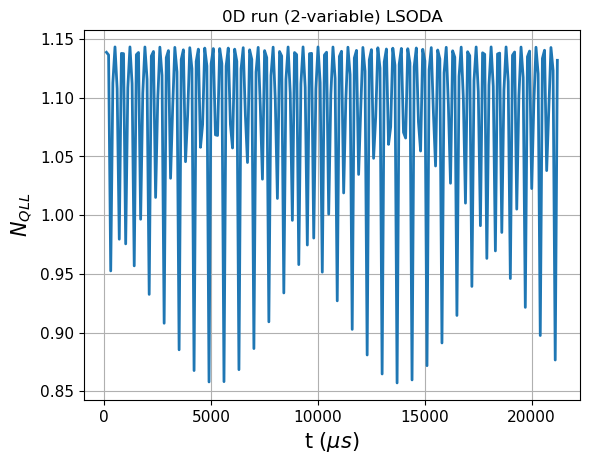

In [6]:
# Growth statistics
delta_Ntot_0D = Ntotkeep_0D[-1]-Ntot_init_0D
growthrate_0D_mlyperus = delta_Ntot_0D/tlast # monolayer/us
growthrate_0D = growthrate_0D_mlyperus*umpersec_over_mlyperus # um/sec
print( "0-D Modeled growth rate, um/s", growthrate_0D)
print( "0-D Modeled growth rate, ml/us", growthrate_0D_mlyperus)
alpha_0D = growthrate_0D/nu_kin/sigmaIcorner
print( "0-D Modeled alpha", alpha_0D)
title = '0D run (2-variable) '+odemethod

# Plot results
plt.figure()
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.plot(tkeep_0D,NQLLkeep_0D,lw=linewidth)
plt.xlabel(r't ($\mu s$)',fontsize=fontsize)
plt.ylabel(r'$N_{QLL} $',fontsize=fontsize)
plt.grid('on')
plt.title(title)

### This is the 1-d run

In [7]:
# Bundle parameters for ODE solver
params = [Nbar, Nstar, sigmaI, sigma0, nu_kin_mlyperus, Doverdeltax2, nx] 

# Initialize as a pre-equilibrated layer of liquid over ice
Ntot_init_1D = np.ones(nx)

# Initialize the keeper arrays
tkeep_1D = []
ykeep_1D = []
tlast = t_init

# Call the ODE solver
ylast = np.array(Ntot_init_1D)
print(np.shape(ylast))
counter = 0
layer = 0
ttot = 0.0
while True:
    # Integrate up to next time step
    sol = solve_ivp(ds.f1d_solve_ivp_1var, tinterval, ylast, args=(params,),rtol=1e-12,method=odemethod)
    ylast = sol.y[:,-1]
    tlast += deltat
        
    # Stuff into keeper arrays
    ykeep_1D.append(ylast)
    tkeep_1D.append(tlast)

    # Make some local copies
    ttot += deltat

    # Update counters and see whether to break
    Ntotlast = ylast
    minpoint = min(Ntotlast)
    maxpoint = max(Ntotlast)
    print(counter-1, int(Ntotlast[0]), maxpoint-minpoint)
    counter += 1
    if uselayers:
        if Ntotlast[0] > layermax_1D-1:
            break
    else:
        if counter > countermax_1D-1:
            break

(301,)
-1 5 0.02235949971845752
0 10 0.06570389367442075
1 15 0.5324411606204862
2 19 0.10624679207220211
3 24 0.16422553212246171
4 29 0.7716665764653179
5 34 0.291367540209464
6 38 0.2982644114079278
7 43 0.875132243664325
8 48 0.7594255985655707
9 52 0.5327566164169397
10 57 0.9471202394439686
11 62 0.9516574456296212
12 67 0.9320516105569823
13 71 1.0145993115293805
14 76 1.0453049923556534
15 81 1.5125497587555117
16 85 1.102342800194748
17 90 1.1280181013902393
18 95 1.7440210633054392
19 100 1.3005773494103892
20 104 1.2310419773966146
21 109 1.8524707030712904
22 114 1.7508997186644706
23 118 1.399586226995126
24 123 1.9271118964975216
25 128 1.9296199500447386
26 133 1.7479072401422115
27 137 1.9934832954973274
28 142 2.0168694333274857
29 147 2.368730982417844
30 151 2.0709070764725936
31 156 2.088776030427084
32 161 2.668009587918931
33 165 2.207122704623572
34 170 2.169119216596499
35 175 2.8010503892810448
36 180 2.5782873250732052
37 184 2.28259312737967
38 189 2.88394566

In [8]:
# Convert results to a numpy array
ykeep_1D = np.array(ykeep_1D, np.float64)
Ntotkeep_1D = ykeep_1D
NQLLkeep_1D = ds.getNQLL(Ntotkeep_1D,Nstar,Nbar)
tkeep_1Darr = np.array(tkeep_1D, np.float64)

1-D growth rate, ml/us 0.04652429789871721
1-D growth rate, um/s 13.957289369615163
1-D alpha 0.26585313084981266
slowdown -1.35 %
Libbrecht's predicted growth rate 10.043193213321738 um/s
Libbrecht's predicted alpha 0.1912989183489855


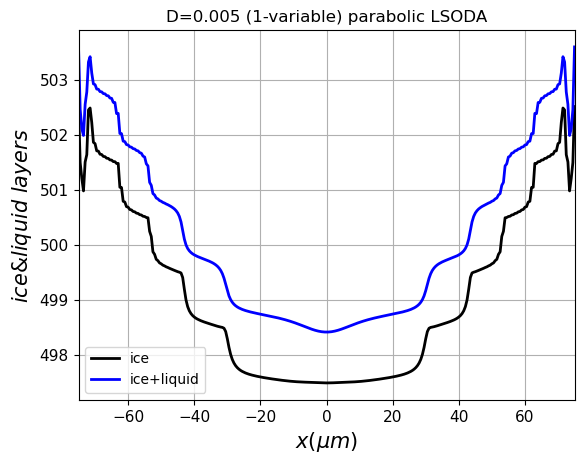

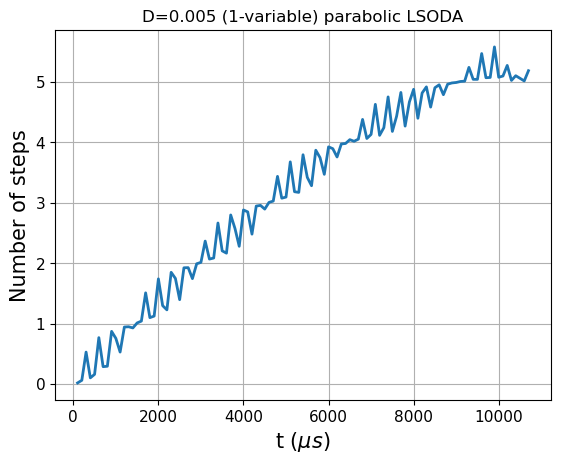

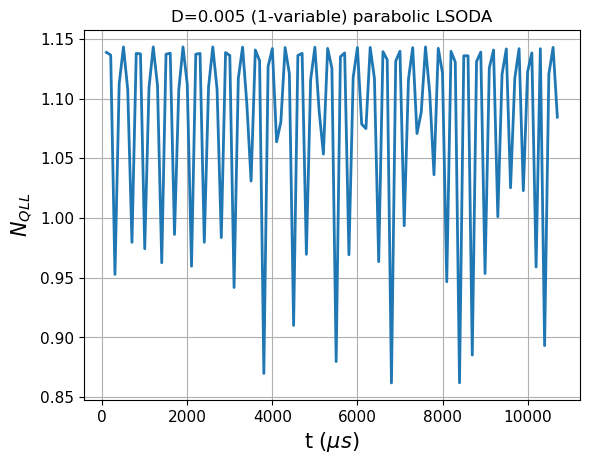

In [9]:
# Growth statistics
delta_Ntot_1D = Ntotkeep_1D[-1,0]-Ntotkeep_1D[0,0]
growthrate_1D_mlyperus = delta_Ntot_1D/tlast; print( "1-D growth rate, ml/us", growthrate_1D_mlyperus)
growthrate_1D = growthrate_1D_mlyperus*umpersec_over_mlyperus; print( "1-D growth rate, um/s", growthrate_1D)
alpha_1D = growthrate_1D/nu_kin/sigmaIcorner; print( "1-D alpha", alpha_1D)
slowdown = (alpha_1D-alpha_0D)/alpha_0D*100; print("slowdown", int(slowdown*100)/100,'%')
Nicekeep_1D = Ntotkeep_1D-NQLLkeep_1D
title = 'D='+str(D)+' (1-variable) '+sigmaIstyle+' '+odemethod

# Comparisons with Libbrecht
sigma0_L = 0.08
A_L = .28
alpha_L = A_L*np.exp(-sigma0_L/sigmaIcorner)
print("Libbrecht's predicted growth rate", nu_kin*alpha_L*sigmaIcorner, "um/s")
print("Libbrecht's predicted alpha", alpha_L)

# Plot ice and liquid, last time step
plt.figure()
plt.plot(x-xmid, Nicekeep_1D[-1,:], 'k', label='ice', lw=linewidth)
plt.plot(x-xmid, Ntotkeep_1D[-1,:], 'b', label='ice+liquid', lw=linewidth)
plt.xlabel(r'$x (\mu m$)',fontsize=fontsize)
plt.ylabel(r'$ice & liquid \ layers$',fontsize=fontsize)
plt.xlim([-xmid, xmid])
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.legend()
plt.title(title)
plt.grid('on')

# Plot number of steps over time
plt.figure()
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
f = np.max(Ntotkeep_1D,axis=1) - np.min(Ntotkeep_1D,axis=1)
plt.plot(tkeep_1D,f,lw=linewidth)
plt.xlabel(r't ($\mu s$)',fontsize=fontsize)
plt.ylabel('Number of steps',fontsize=fontsize)
plt.title(title)
# plt.ylim([9,10])
plt.grid('on')

# Plot QLL over time, at the corner
plt.figure()
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.plot(tkeep_1D,NQLLkeep_1D[:,0],lw=linewidth)
plt.xlabel(r't ($\mu s$)',fontsize=fontsize)
plt.ylabel(r'$N_{QLL} $',fontsize=fontsize)
plt.title(title)
plt.grid('on')

### The cell below is just backup for parameters, and allows some exploration (but not part of the simulation)

In [10]:
# The time required for an initial gaussian to diffuse
layer_growth_rate = growthrate_0D/umpersec_over_mlyperus; print('Layer growth rate =', layer_growth_rate)
t = 1/layer_growth_rate; print('Time to add a layer =', t)
t = 2.5**2/D; print('Time to diffuse across a terrace =', t)
t = deltax**2/D; print('Time for equilibration across dx =', t)
t = 0.001; print('Time for ice-QLL equilibration =', t)

# How a change in the crystal size could be used to calculate a new diffusion coefficient with the same D/dx^2
D_old = 2e-6
D_new = D_old/50**2*100**2; print(D_new)

# Computing the kinetic deposition velocity ... roughly, 260 
import numpy as np
M = 18 # g/mol
T = 260 # K
NA = 6.02e23
m = M/NA; print(m,'mass of a molecule of water, grams/mol')
m /= 1e3; print(m,'mass of a molecule of water, kg/mol')
R = 8.314 # J/K-mol
k = R/NA; print(k,"Boltzmann's constant, J/K")

Pvap = 200 # Pascals (see https://byjus.com/clausius-clapeyron-equation-calculator/)
V_gas = R*T/Pvap # Must be in m^3
V_gas *= (10/1)**3; print(V_gas, 'Liters') 
V_gas *= (10/1)**3; print(V_gas, 'cm^3') # see https://www.omnicalculator.com/physics/ideal-gas-law
c_sat = 1/V_gas # mol/cm^3
c_sat*=M; print(c_sat,'density of vapor, g/cm^3')

c_solid = 0.92; print(c_solid, 'density of ice, g/cm^3')
V_solid = 1/c_solid # cm^3/g

V_ratio = V_gas/V_solid; print(V_ratio,'ratio of volumes')
c_ratio = c_sat/c_solid; print(c_ratio,'ratio of densities')

sqrtfactor = np.sqrt(k*T/(2*np.pi*m))
nukin = c_sat/c_solid*sqrtfactor; print(nukin,'kinetic velocity, m/s')
nukin *= 1e6; print(nukin, 'kinetic velocity, um/s')

# Computing the kinetic deposition velocity ... roughly, 240 K has nukin of 40 um/s (we used 49 um/s in the paper)
M = 18 # g/mol
T = 240 # K
NA = 6.02e23
m = M/NA; print(m,'mass of a molecule of water, grams/mol')
m /= 1e3; print(m,'mass of a molecule of water, kg/mol')
R = 8.314 # J/K-mol
k = R/NA; print(k,"Boltzmann's constant, J/K")

Pvap = 26 # Pascals (see https://byjus.com/clausius-clapeyron-equation-calculator/)
V_gas = R*T/Pvap # Must be in m^3
V_gas *= (10/1)**3; print(V_gas, 'Liters') 
V_gas *= (10/1)**3; print(V_gas, 'cm^3') # see https://www.omnicalculator.com/physics/ideal-gas-law
c_sat = 1/V_gas # mol/cm^3
c_sat*=M; print(c_sat,'density of vapor, g/cm^3')

c_solid = 0.92; print(c_solid, 'density of ice, g/cm^3')
V_solid = 1/c_solid # cm^3/g

V_ratio = V_gas/V_solid; print(V_ratio,'ratio of volumes')
c_ratio = c_sat/c_solid; print(c_ratio,'ratio of densities')

sqrtfactor = np.sqrt(k*T/(2*np.pi*m))
nukin = c_sat/c_solid*sqrtfactor; print(nukin,'kinetic velocity, m/s')
nukin *= 1e6; print(nukin, 'kinetic velocity, um/s')

# Gladich et al recommendation
D_Gladich = 0.16e-9 # m^2/s
D_Gladich *= (1e6/1)**2*(1/1e6); print('Gladich says, for 260 K, D = ', D_Gladich)

Layer growth rate = 0.047161033616473017
Time to add a layer = 21.203945785673092
Time to diffuse across a terrace = 1250.0
Time for equilibration across dx = 50.0
Time for ice-QLL equilibration = 0.001
8e-06
2.990033222591362e-23 mass of a molecule of water, grams/mol
2.9900332225913625e-26 mass of a molecule of water, kg/mol
1.381063122923588e-23 Boltzmann's constant, J/K
10808.199999999999 Liters
10808199.999999998 cm^3
1.6654021946300035e-06 density of vapor, g/cm^3
0.92 density of ice, g/cm^3
9943543.999999998 ratio of volumes
1.810219776771743e-06 ratio of densities
0.0002502630900698087 kinetic velocity, m/s
250.26309006980867 kinetic velocity, um/s
2.990033222591362e-23 mass of a molecule of water, grams/mol
2.9900332225913625e-26 mass of a molecule of water, kg/mol
1.381063122923588e-23 Boltzmann's constant, J/K
76744.61538461539 Liters
76744615.38461539 cm^3
2.345441424103921e-07 density of vapor, g/cm^3
0.92 density of ice, g/cm^3
70605046.15384616 ratio of volumes
2.5493928